In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.integrate import trapezoid
from Utilities.basic_units import radians
from Utilities.time_extractor import days_since_distruption

from Utilities.operators import make_tree, to_cylindric, from_cylindric
import Utilities.prelude
import src.orbits as orb
from Utilities.sections import make_slices

<Figure size 800x600 with 0 Axes>

In [2]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Low'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '164'
path = f'TDE/{folder}{check}/{snap}'
Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
theta_lim = 7*np.pi/8
step = 0.02
theta_params = [-theta_lim, theta_lim, step]
theta_arr = np.arange(*theta_params)

In [3]:
def find_sz_plane(theta_data, r_data, z_data, f_data, theta_orbit, r_orbit, a = Rp, arc_length = True):
    """
    Parameters
    --------
    theta_data, r_data, z_data, f_data: array.
        (ALL) Simulation cells' values of THETA_cyl, R_cyl, Z, quantity f.
    theta_orbit, r_orbit: array.
        Orbit's angles/radii.
    Returns
    --------
    f_sz, z_sz, theta_broadcast: array.
        (Broadcasted) profile of f (and the corresponding height)  for each point on the orbit
    """
    f_sz = []
    z_sz = []
    for i,theta in enumerate(theta_orbit):
        condition_theta = np.abs(theta-theta_data)<0.08
        condition_r = np.abs(r_orbit[i]-r_data)<0.08
        condition = np.logical_and(condition_theta, condition_r)
        f_sz.append(f_data[condition])
        z_sz.append(z_data[condition])

    # Broadcast so that then you can easily plot
    length = np.zeros(len(z_sz))
    for i in range(len(z_sz)):
        length[i] = int(len(z_sz[i]))
    theta_broadcast = np.repeat(theta_orbit, list(length))
    f_sz = np.concatenate(f_sz)
    z_sz = np.concatenate(z_sz)

    if arc_length:
        s_data = orb.find_arclenght(theta_orbit, r_orbit)
        s_broadcast = np.repeat(s_data, list(length))
        return f_sz, z_sz, theta_broadcast, s_broadcast
    else:
        return f_sz, z_sz, theta_broadcast

def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 


Load data

In [4]:
data = make_tree(path, snap, is_tde = True, energy = False)
dim_cell = data.Vol**(1/3)

THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
# R = np.sqrt(X**2 + Y**2 + Z**2)
# Vcyl = np.sqrt(VX**2 + VY**2)
# V = np.sqrt(VX**2 + VY**2 + VZ**2)
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, Temp_midplane, = \
    make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den, data.Temp], midplane)

days after disruption: 1.3532153925058021 // t_fall: 2.5777261297507925 // sim_time: 73.40236449912129


In [6]:
x_cm, y_cm = orb.find_maximum(X_midplane, Y_midplane, dim_midplane, Den_midplane, theta_arr, Rt)
r_cm = np.sqrt(x_cm**2 + y_cm**2)
# find where in cm the y value fall of 1 order of magnutude with respect to the previous value
r_kep = orb.keplerian_orbit(theta_arr, a = Rt/2, Rp = Rp, ecc=1)
x_kep, y_kep = from_cylindric(theta_arr, r_kep)
s_data_kep, _ = orb.find_arclenght(theta_arr, r_kep,  a = Rt/2, Rp = Rp, ecc=1, choose='Keplerian')
s_data_cm, idx = orb.find_arclenght(theta_arr, [x_cm, y_cm],  a = Rt/2, Rp = Rp, ecc=1, choose='Maxima')

Text(0, 0.5, '$R [R_\\odot]$')

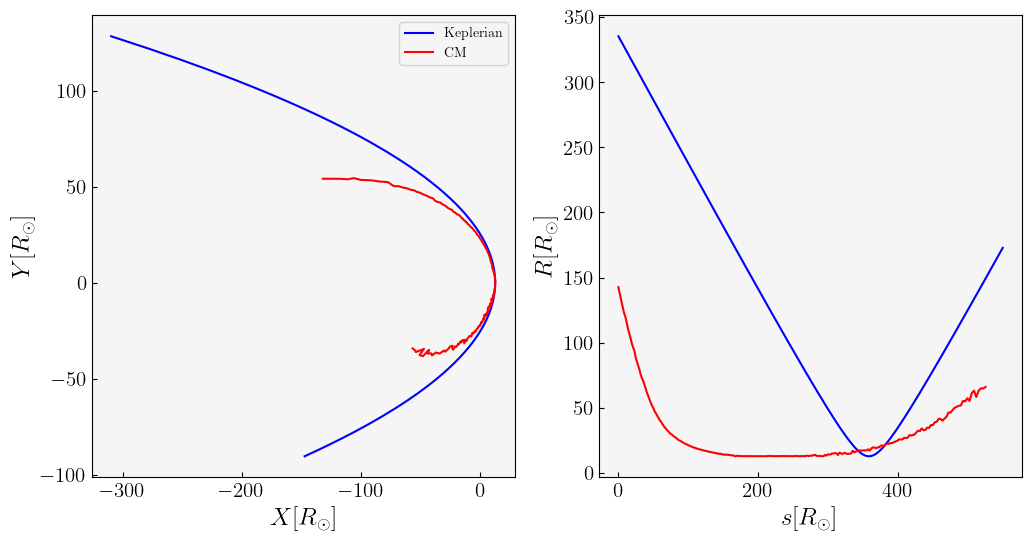

In [13]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(x_kep[:idx], y_kep[:idx], c= 'b', label = 'Keplerian')
ax[0].plot(x_cm[:idx], y_cm[:idx], c='r', label = 'CM')
#ax[0].set_xlim(-300, 30)
#ax[0].set_ylim(-100,100)
ax[0].legend()
ax[0].set_xlabel(r'$X [R_\odot]$', fontsize = 18)
ax[0].set_ylabel(r'$Y [R_\odot]$', fontsize = 18)

ax[1].plot(s_data_kep[:idx], r_kep[:idx], c = 'b')
ax[1].plot(s_data_cm, r_cm[:idx], c = 'r')
ax[1].set_xlabel(r'$s [R_\odot]$', fontsize = 18)
ax[1].set_ylabel(r'$R [R_\odot]$', fontsize = 18)

Y-Z plane. We want to reproduce Shiokawa+15 (note that you have to considr the tangent plane at pericenter, i.e. a cross section along X=Rp for us)

In [ ]:
cross_sect = np.abs(data.X-Rp)< dim_cell
lim = np.logical_and(np.abs(data.Y)<100, np.abs(data.Z)<50)
shio = np.logical_and(cross_sect, lim)


Y_shio, Z_shio, VY_shio, VZ_shio, Den_shio, Entropy_shio = make_slices([data.Y, data.Z, data.VY, data.VZ, data.Den, data.Entropy], shio)
shio_tree = KDTree(np.transpose([Y_shio, Z_shio]))


# extend data for the plot
Y_shio_interp = np.arange(np.min(Y_shio), np.max(Y_shio))
Z_shio_interp = np.arange(np.min(Z_shio), np.max(Z_shio), 0.1)
Entropy_shio_interp = np.zeros((len(Y_shio_interp), len(Z_shio_interp)))

for i in range(len(Y_shio_interp)):
    for j in range(len(Z_shio_interp)):
        point = np.array([Y_shio_interp[i], Z_shio_interp[j]])
        _, idx = shio_tree.query(point)
        Entropy_shio_interp[i, j] = Entropy_shio[idx]


In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
img = ax[0].scatter(Y_shio, Z_shio, c = np.log10(Den_shio), s = 4, cmap = 'jet', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
ax[0].set_xlim(-40,40)
# ax[0].gca().invert_xaxis()
ax[0].set_ylim(-15,15)
ax[0].set_xlabel(r'Y [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(Y_shio, Z_shio, c = Entropy_shio, s = 4, cmap = 'jet', vmin = 1.5e-6, vmax = 3.5e-6)
cbar = plt.colorbar(img1)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-15,15)
ax[1].set_xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()

plt.tight_layout()
plt.suptitle(r'Cross section, X = $R_p$', fontsize = 16)


In [ ]:
plt.figure(figsize = (8,6))
img = plt.pcolormesh(Y_shio_interp, Z_shio_interp, Entropy_shio_interp.T, cmap = 'jet', vmin = 1.5e-6, vmax = 3.5e-6)
plt.quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
# plt.scatter(y_surf_shio, z_surf_shio, s = 4, color='k')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section at X = $R_p$', fontsize = 16)

Midplane and orbit

In [ ]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

S-Z plane

In [ ]:
Den_sz, Z_sz, theta_broad, s_broadcast = find_sz_plane(THETA, RADIUS_cyl, Z, Den, theta_arr, orbit)

In [ ]:
z0_Nick_idx = np.where(np.abs(R-Rt)<0.001)[0]
z0_Nick_idx_selected = z0_Nick_idx[::10]
z_Nick = np.array(Z[z0_Nick_idx_selected])

In [ ]:
z_arr = np.arange(-10, 10)

In [ ]:
free_fall = []
theta_Nick = np.arange(-np.pi/2, np.pi/2 , 0.1)
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_Nick)
    free_fall.append(z)

In [ ]:
plt.figure(figsize=(8,4))
img = plt.scatter(theta_broad * radians, Z_sz, c = np.log10(Den_sz), xunits = radians, s= 4, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
plt.ylim(-5,5)
plt.xlim(theta_broad[0] * radians, theta_broad[-1] * radians)
plt.xlabel(r'$\theta$', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)

for i in range(len(z_arr)):
    plt.plot(theta_Nick, free_fall[i], c = 'k', alpha = 0.6)

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
img = plt.scatter(s_broadcast, Z_sz, c = np.log10(Den_sz), s= 4, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# plt.xlim(s_broadcast[0], s_broadcast[-1])
plt.xlim(50, 300)
plt.ylim(-5,5)
plt.xlabel(r'$s [R_\odot]$', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)

In [ ]:
idx_pericenter = np.argmin(np.abs(theta_arr))

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,4))

ax[0].plot(s_data, orbit, c = 'saddlebrown')
ax[0].scatter(s_data[idx_pericenter], orbit[idx_pericenter], c = 'k')
ax[0].plot(s_upper_data, lower_orbit, c = 'goldenrod')
ax[0].plot(s_lower_data, upper_orbit, c = 'goldenrod')
ax[0].set_xlabel(r'$s [R_\odot]$', fontsize = 18)
ax[0].set_ylabel(r'R [$R_\odot$]', fontsize = 18)
ax[0].set_xlim(0,350)
ax[0].set_title('BH framework', fontsize = 14)

ax[1].plot(s_data, orbit - orbit, c = 'saddlebrown')
ax[1].plot(s_upper_data, lower_orbit - orbit, c = 'goldenrod')
ax[1].plot(s_lower_data, upper_orbit - orbit, c = 'goldenrod')
ax[1].set_xlabel(r'$s [R_\odot]$', fontsize = 18)
ax[1].set_xlim(0,350)
ax[1].set_title('Stream framework', fontsize = 14)

plt.tight_layout()